In [1]:
import matplotlib

import numpy as np
import pandas as pd
import os
import glob
import pickle
import math
import regex as re
from itertools import groupby, count

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.colors as mcolors

from matplotlib import collections  as mc
import matplotlib.cm as cm

from scipy.special import ellipe, ellipeinc
import scipy as sp
import scipy.optimize
from scipy.spatial import distance
from scipy import interpolate

import scipy.signal

/sw/apps/python3/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def load_timepoints(glob_path, last_timepoint_only = False, npart = 120):

    for i, path in enumerate(glob.glob(glob_path)):

        try: 
            df_temp = pickle.load(open(glob.glob(path + 'database.pickle')[0], "rb"))
        except: 
            
            try: 
                df_temp = pickle.load(open(glob.glob(path + 'database_duplicate.pickle')[0], "rb"))
            except: 
                print('files corrupted or empty path: ' + path)
                continue

        print(path)

        bool_ind = df_temp.N_iter == np.max(df_temp.N_iter)

        if last_timepoint_only: 
            df_temp = df_temp[bool_ind].reset_index()[:npart]

        else: 
            df_temp['final_tp'] = np.where(bool_ind, True, False)

        #split path name (path name will be split by numerical values)
        #to get all parameter names
        param_names = re.split(r'_[+\-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+)?_*', path.split('/')[-2])

        #usually get an empty string as a result of splitting
        if '' in param_names:
            param_names.remove('')

        #for each param name, grab its value
        for param in param_names:   
            param_val = re.findall(param + '_[+\-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+)?_*', path)
            val = float(re.findall('[+\-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+)?', param_val[0])[-1])

            #for each param, make a column in the dataframe and save the parameter value there
            df_temp[param] = val

        #print(len(df_temp))

        if i == 0:
            df = df_temp
        else: 
            df = pd.concat(
                            [df, df_temp],
                            axis=0,
                            join="outer",
                            ignore_index=True,
                            keys=None,
                            levels=None,
                            names=None,
                            verify_integrity=False,
                            copy=True,
                        )
            
    return df

In [3]:
#from https://stackoverflow.com/questions/22959698/distance-from-given-point-to-given-ellipse
def get_closest_ellipse_pt(semi_major, semi_minor, p): 
    
    px = abs(p[0])
    py = abs(p[1])

    tx = 0.707
    ty = 0.707

    a = semi_major
    b = semi_minor

    for x in range(0, 3):
        x = a * tx
        y = b * ty

        ex = (a*a - b*b) * tx**3 / a
        ey = (b*b - a*a) * ty**3 / b

        rx = x - ex
        ry = y - ey

        qx = px - ex
        qy = py - ey

        r = math.hypot(ry, rx)
        q = math.hypot(qy, qx)

        tx = min(1, max(0, (qx * r / q + ex) / a))
        ty = min(1, max(0, (qy * r / q + ey) / b))
        t = math.hypot(ty, tx)
        tx /= t 
        ty /= t 

    return (math.copysign(a * tx, p[0]), math.copysign(b * ty, p[1]))

In [4]:
#from https://stackoverflow.com/questions/6972331/how-can-i-generate-a-set-of-points-evenly-distributed-along-the-perimeter-of-an
def angles_in_ellipse(num, a, b):
    assert(num > 0)
    assert(a < b)
    angles = 2 * np.pi * np.arange(num) / num
    if a != b:
        e = (1.0 - a ** 2.0 / b ** 2.0) ** 0.5
        tot_size = sp.special.ellipeinc(2.0 * np.pi, e)
        arc_size = tot_size / num
        arcs = np.arange(num) * arc_size
        res = sp.optimize.root(
            lambda x: (sp.special.ellipeinc(x, e) - arcs), angles)
        angles = res.x 
    return angles, tot_size

In [5]:
def get_half_ellipse_xs_ys(R_vert_frac, R, Npoints, normalize = False):
    phi, ellipse_len = angles_in_ellipse(2*Npoints, R_vert_frac, 1)
    
    if not normalize: 
        ellipse_len = 2

    phi -= np.pi/2

    xs = 2*R/ellipse_len*np.cos(phi)
    ys = 2*R_vert_frac/ellipse_len*np.sin(phi)

    xs = xs[ys > 0]
    ys = ys[ys > 0]
    
    return(xs, ys)

In [26]:
def plot_param_sweep(df, cols_param, rows_param, 
                     constant_params, constant_param_vals, 
                     shape = 'circle', R_vert_frac = None, q_time = None,
                     plot_vit = True, plot_CFs = False, CFs = None, plot_MDs = False, R_vit = 1, 
                     text_col = None, text = None, textsize = 20, 
                     labelsize = 30, ax_labels = [],
                     vitelline_kwargs = {'c': 'k', 'lw' : 5, 'alpha': 0.2}, 
                     tissue_kwargs = {'c': '#03b6fc', 'lw' : 3},
                     CF_kwargs = {'c': 'y', 'lw' : 3},
                     MD_kwargs = {'c': '#b0258d', 'lw' : 3}):

    #TO DO:
    #- would also be good to be able to pass axis labels as strings
    #- legend? 
    #- plot title
    
    ##########################
    #########################
    #GET PARAM COMBINATIONS: 
    
    row_vals = np.unique(df[rows_param])
    col_vals = np.unique(df[cols_param])
    
    if type(constant_param_vals) == list:
        const_bool = np.sum(np.abs(df[constant_params] - constant_param_vals) < 0.01, axis = 1) == len(constant_params)
    elif constant_params is None: 
        const_bool = True
    else: 
        #const_bool = np.abs(df[constant_params] - constant_param_vals) < 0.1  
        const_bool = df[constant_params] == constant_param_vals

    params_to_plot = [rows_param, cols_param]

    #grabs all combinations of parameters that are present in the dataframe
    #param_combinations = df[params_to_plot].drop_duplicates()

    #sorts the parameters so that both axes will be plotted in an increasing order
    #and reshapes them into a 3d array, where the first 2 dimensions correspond to the dimensions on the plot
    #and the third dimension holds parameter values to be plotted at each subplot
    X, Y = np.meshgrid(np.sort(col_vals), -np.sort(-row_vals))
    param_array = np.dstack([Y,X])

    x_max = np.max(df[const_bool].x)
    x_min = np.min(df[const_bool].x)

    if x_min < 0: 
        x_max = np.abs(x_min)

    y_max = np.max(df[const_bool].y)
    y_min = np.min(df[const_bool].y)

    if y_min < 1e-4:
        y_min = -0.25*y_max
        
    #print(y_min, y_max, x_min, x_max)
    
    ##########################
    #########################
    #SET UP VITELLINE MEMBRANE & PLOT SIZE: 

    if shape == 'circle':
        #for plotting vitelline membrane
        thetas = np.arange(0, 2*np.pi, 2*np.pi/100)
        xs = [R_vit*np.cos(theta) for theta in thetas]
        ys = [R_vit*np.sin(theta) for theta in thetas]

        plot_width = 5
        plot_height = 5

    elif shape == 'ellipse':
        xs, ys = get_half_ellipse_xs_ys(R_vert_frac, 1, 100)

        plot_width = 10
        plot_height = 10*R_vert_frac

    elif 'R_vert_frac' in constant_params:
        R_vert_frac = constant_param_vals[constant_params == 'R_vert_frac']

        xs, ys = get_half_ellipse_xs_ys(R_vert_frac, 1, 100)

    elif shape == 'line':
        xs = np.linspace(min(df.x), max(df.x), 50)
        ys = np.zeros(50)

        plot_width = 12
        plot_height = plot_width * ((y_max - y_min)/(x_max-x_min))
        
        if plot_height < 2: 
            y_max = 1/12 * (x_max-x_min)
            y_min = -1/12 * (x_max-x_min)
            plot_height = plot_width * ((y_max - y_min)/(x_max-x_min))
            
        #print(plot_width, plot_height)

    ##########################
    #########################
    #GENERATE FIGURE &  SET UP SUBPLOTS:

    fig, axs = plt.subplots(len(np.unique(df[rows_param])),len(np.unique(df[cols_param])), 
                        figsize=(len(col_vals)*plot_width, len(row_vals)*plot_height), facecolor='white')
    try: 
        if len(axs.shape) == 1:
            if len(row_vals) == 1: 
                axs = axs.reshape(1,-1)
            elif len(col_vals) == 1: 
                axs = axs.reshape(-1,1)
    except: 
        axs = np.array([np.array([axs])])

    main_ax = fig.add_subplot(111, frameon=False)


    ##########################
    #########################
    #PLOT PARAM SWEEP: 

    for i, row in enumerate(param_array):

        for j, param_vals in enumerate(row):
            #print(param_vals)

            if shape == 'ellipse': 
                ellipse_bool = True
            else: 
                ellipse_bool = False


            if 'R_vert_frac' in rows_param:
                R_vert_frac = param_vals[0]
                ellipse_bool = True

            elif 'R_vert_frac' in cols_param:
                R_vert_frac = param_vals[1]
                ellipse_bool = True

            if ellipse_bool: 
                if R_vert_frac == 1: 
                    thetas = np.arange(0, np.pi, np.pi/100)
                    xs = [R_vert_frac*np.cos(theta)/3.14 for theta in thetas]
                    ys = [R_vert_frac*np.sin(theta)/3.14 for theta in thetas]

                else: 
                    xs, ys = get_half_ellipse_xs_ys(R_vert_frac, 1, 100, True)


            ###################
            #PLOT VITELLINE MEMBRANE
            if plot_vit: 
                axs[i,j].plot(xs, ys, **vitelline_kwargs)


            if (ellipse_bool == True) & (R_vert_frac == 0):
                axs[i, j].set_xlim([-0.1,1.1])
            else: 
                axs[i, j].set_xlim([x_min - 0.1*np.abs(x_min),x_max + 0.1*x_max])

            axs[i, j].set_ylim([y_min - 0.1*np.abs(y_min) ,y_max + 0.1*y_max])
            axs[i, j].set_aspect('equal', adjustable='box')
            
            ###################
            #PLOT TISSUE:
            
            bool_ind = (np.sum(df[params_to_plot] == param_vals, axis = 1) == len(params_to_plot)) & const_bool 
            
            #add time to bool_ind
            if not (q_time is None): 
                time_bool = np.abs(df.t - q_time) == np.min(np.abs(df[bool_ind].t - q_time))
                bool_ind = (time_bool) & (bool_ind)
            
            #add seed column if not already in dataframe:
            if not ('seed' in df[bool_ind].columns):
                df['seed'] = 1
            
            #if multiple seeds plotted at the same time, each plotted as a separate line
            for seed in np.unique(df[bool_ind].seed):
                plot_bool = (bool_ind) & (df.seed == seed)

                if shape == 'circle':
                    axs[i,j].plot(np.append(df[plot_bool].x, df[plot_bool].x.iloc[0]), 
                                np.append(df[plot_bool].y, df[plot_bool].y.iloc[0]), 
                               **tissue_kwargs) 
                else: 
                    axs[i,j].plot(df[plot_bool].x, 
                                  df[plot_bool].y,
                                  **tissue_kwargs)

            ###################
            #PLOT MDs & CF: 
            
            for seed in np.unique(df[bool_ind].seed):
                plot_bool = (bool_ind) & (df.seed == seed)
            
                if plot_MDs: 
                    #grabs the indices of particles belonging to mitotic domains
                    md_indices = df[plot_bool & df.mitotic_domain].ID.values
                    #this splits the list of all indices of all particles belonging to mitotic domains into lists of consecutive integers
                    #so basically into separate mitotic domains
                    mds = [list(g) for k, g in groupby(md_indices, key=lambda i,j=count(): i-next(j))]

                    for md in mds: 
                        md_bool = df.ID.isin(md)

                        axs[i,j].plot(df[(plot_bool) & md_bool].x, df[(plot_bool) & md_bool].y, **MD_kwargs)

                if plot_CFs: 
                    for CF in CFs: 
                        CF_bool = df.ID.isin(CF)
                        axs[i,j].plot(df[(plot_bool) & CF_bool].x, df[(plot_bool) & CF_bool].y, **CF_kwargs)

            #debug - check whether axis labelling is consistent with values plotted
            #axs[i, j].text(0, 0, str(param_vals), ha = 'center')

            ###################
            #ADD TEXT
            if not (text_col is None): 
                text_value = np.unique(df[bool_ind][text_col])[0]
                #n_iter = np.round(np.unique(df[bool_ind].N_iter)[0])

                x_offset = max(0.1, 0.1*np.abs(x_min))

                axs[i,j].text(x_min + x_offset, y_max, 
                              f'{text}: {text_value:.1f}', 
                              ha = 'center', size = textsize)

    ##########################
    #########################
    #ADJUST AXES/LABELS etc: 
    if ax_labels:
        xlabel = ax_labels[0]
        ylabel = ax_labels[1]
    else:
        xlabel = cols_param
        ylabel = rows_param

    #removes subplot axes
    [axi.set_axis_off() for axi in axs.ravel()]

    # set labels
    #plt.setp(axs[-1, :], xlabel=['x axis label', 'x axis label2'])
    #plt.setp(axs[:, 0], ylabel='y axis label')
    fig.tight_layout()
    #removes spaces between subplots - ensures better alignment of tick labels and plots
    plt.subplots_adjust(wspace=0, hspace=0)


    plt.xlabel(xlabel, fontsize = labelsize, labelpad = 30)
    plt.ylabel(ylabel, fontsize = labelsize, labelpad = 30)

    plt.xlim(0,1)
    plt.ylim(0,1)

    tick_intervals_x = np.arange((1/len(np.unique(df[cols_param])))/2, 1, 1/len(np.unique(df[cols_param])))
    tick_intervals_y = np.arange((1/len(np.unique(df[rows_param])))/2, 1, 1/len(np.unique(df[rows_param])))

    #kind of hacky at the moment - divides the axis into intervals based on the number of parameters plotted on 
    #x/y-axis and puts a tick label at the center of each interval
    #for this to be well aligned, you can't have axes or axes labels of individual subplots
    plt.xticks(tick_intervals_x, [f'{param:.2g}' for param in np.sort(np.unique(df[cols_param]))], fontsize = textsize)
    plt.yticks(tick_intervals_y, [f'{param:.2g}' for param in np.sort(np.unique(df[rows_param]))], fontsize = textsize)

    #plt.title('Time = ' + str(round(times[t_i])))

    main_ax.tick_params(axis=u'both', which=u'both',length=0)
    
    return fig


In [7]:
def get_furrow_indices(df, curv_thresh): 
    
    #want to find folds in the tissue 
    #usually this will be either minimum/maximum of curvature (dep. on how curvature is defined)
    #with the edges of the fold being the maxima (if center of fold is a minimum) or minima (otherwise)
    #around it
    
    curvatures = df.curvature
    
    if not (np.all(df.R_vert_frac == 0)): #np.all(df.MD_growth_const_l0 == 1) &
        curvatures = -df.curvature
            
        #if growth constant = 0 and not a line or a circle!
        #if np.all(df.MD_growth_const_l0 == 0) & (not (np.all(df.R_vert_frac == 0) | np.all(df.R_vert_frac == 0))):
            #df['old_ID'] = df.ID
            #df.ID = len(df) - df.old_ID -1
            

    minima,  = scipy.signal.argrelextrema(curvatures.values, np.less)
    minima = minima[curvatures.iloc[minima] < -curv_thresh]
    maxima,  = scipy.signal.argrelextrema(curvatures.values, np.greater)
    #maxima = maxima[df.curvature[maxima] > curv_thresh]

    furrow_indices = {}
    furrow_depths = {}

    for minimum in minima:
        width = min(min((maxima - minimum)%len(df)), min((minimum - maxima + len(df))%len(df)))

        #IDs[(np.abs(IDs - minimum + 100)%100 <= width) | ((minimum - IDs + 100)%100 <= width)]
        furrow_indices[minimum], = np.where((np.abs(df.ID - minimum + len(df))%len(df) <= width) | 
                                            ((minimum - df.ID + len(df))%len(df) <= width))

        if 'R_vert_frac' in df.columns: 
            if np.all(df.R_vert_frac == 0):
                furrow_depths[minimum] = df.iloc[minimum].y
            elif np.all(df.R_vert_frac == 1):
                furrow_depths[minimum] = ((1/np.pi) - np.sqrt(df[df.ID == minimum].x**2 + df[df.ID == minimum].y**2)).iloc[0]
            else: 
                R_vert_frac = df.R_vert_frac.values[0]
                xs, ys = get_half_ellipse_xs_ys(R_vert_frac, 1, 2*len(df))

                dist = np.min((df.iloc[minimum].x - xs)**2 + (df.iloc[minimum].y - ys)**2)

                furrow_depths[minimum] = np.sqrt(dist)
        else: 
            furrow_depths[minimum] = 1 - np.sqrt(df[df.ID == minimum].x**2 + df[df.ID == minimum].y**2)
        
    return furrow_indices, furrow_depths

In [8]:
#from https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [9]:
primary_color = '#373F51'
secondary_color = '#539987'
accent_color = '#FF6978'


#CF_color = '#00CECB'
#CF_color = '#ABFAA9'
CF_color = '#2CF6B3'

label_text_size = 16
fig_folder = 'figs'
tick_size = label_text_size - 3

In [36]:
##load files

last_timepoint_only = True

#important param sweeps: 
#MD(curv) + GB + CF 'cephalic_furrow_test'
#MD + GB 'long_rigidity_sweep'
#MD(curv) + GB 'int_curvature_MD_test'
#CF only (MDs added after relaxation) 'cephalic_furrow'
#curvature sweep:
#sweep = '1D_CF/curvatures'

sweep = 'int_curvature_MD_test'




if glob.glob(f'dfs/final_df_{sweep}.pkl'): 
    with open(f'dfs/final_df_{sweep}.pkl', 'rb') as f:
        df_final = pickle.load(f)
else: 
    glob_path = f'/projects/modeslab/{sweep}/cf_sweep*/'

    df_final = load_timepoints(glob_path, last_timepoint_only)

    df_final.to_pickle(f"dfs/final_df_{sweep}.pkl")  


In [37]:
df_final.columns

Index(['index', 'x', 'y', 'arclength', 'arclength_frac', 'mitotic_domain_id',
       'mitotic_domain', 'ID', 'dr0', 'dr0_i-1', 'L+1', 'L-1', 'K', 'K+1',
       'K-1', 'ko', 'ko_i-1', 'ko_i+1', 'z', 't', 'N_iter', 'x_i-2', 'y_i-2',
       'x_i-1', 'y_i-1', 'x_i+1', 'y_i+1', 'x_i+2', 'y_i+2', 'curvature',
       'curvature_i-1', 'curvature_i+1', 'd_r_mod', 'd_r_mod_i-1',
       'd_r_mod_i+1', 'd_r_mod_alternate', 'd_r_mod_alternate_i-1',
       'd_r_mod_alternate_i+1', 'd_curvature_x', 'd_curvature_y',
       'd_curvature_i-1_x', 'd_curvature_i+1_x', 'd_curvature_i-1_y',
       'd_curvature_i+1_y', 'd_energy_x', 'd_energy_y', 'noise_x', 'noise_y',
       'r', 'dx_t', 'dy_t', 'x_t+1', 'y_t+1', 'cf_sweep_K', 'R_vert_frac',
       'noise_iterations', 'seed', 'int_curvature_MD', 'germ_band_push',
       'noise_scale', 'dt', 'number_of_mitotic_domains'],
      dtype='object')

In [13]:
#'int_curvature_MD' 'int_curvature_CF'

df_final.groupby(['cf_sweep_K', 'seed', 'germ_band_push', 'int_curvature_MD']).size().head()

cf_sweep_K  seed  germ_band_push  int_curvature_MD
0.00008     0.0   0.0             -10.0               240
                                  -1.0                240
                                   0.0                240
                  0.2             -10.0               240
                                  -1.0                240
dtype: int64

In [38]:
print(np.unique(df_final.seed))

print(np.max(df_final.t), np.max(df_final.N_iter))

[0. 1. 2. 3. 4.]
9.999999999990033 100000


In [31]:
rows_param = 'cf_sweep_K'
cols_param = 'germ_band_push'
constant_params = ['R_vert_frac', 'seed', 'int_curvature_MD', 'int_curvature_CF']
constant_param_vals = [0.4, 3, -1]#, 10]

constant_params = ['R_vert_frac', 'int_curvature_MD']#, 'int_curvature_CF']
constant_param_vals = [0.4, -1]#, 10]

#constant_params = ['R_vert_frac', 'number_of_mitotic_domains']
#constant_param_vals = [0.4,  4]

df = df_final

shape = 'ellipse'
R_vert_frac = 0.4
q_time = None

plot_CFs = False
CFs = [(50, 51, 52, 53, 54, 55)]
plot_MDs = True
R_vit = 1

text_col = 'n_furrows'
text = 'av furrows'

vitelline_kwargs = {'c': primary_color, 'lw' : 8, 'alpha': 0.3}
tissue_kwargs = {'c': primary_color, 'lw' : 4, 'alpha' : 0.4}
CF_kwargs = {'c': CF_color, 'lw' : 3, 'alpha' : 0.3}
MD_kwargs = {'c': accent_color, 'lw' : 3, 'alpha' : 0.3}

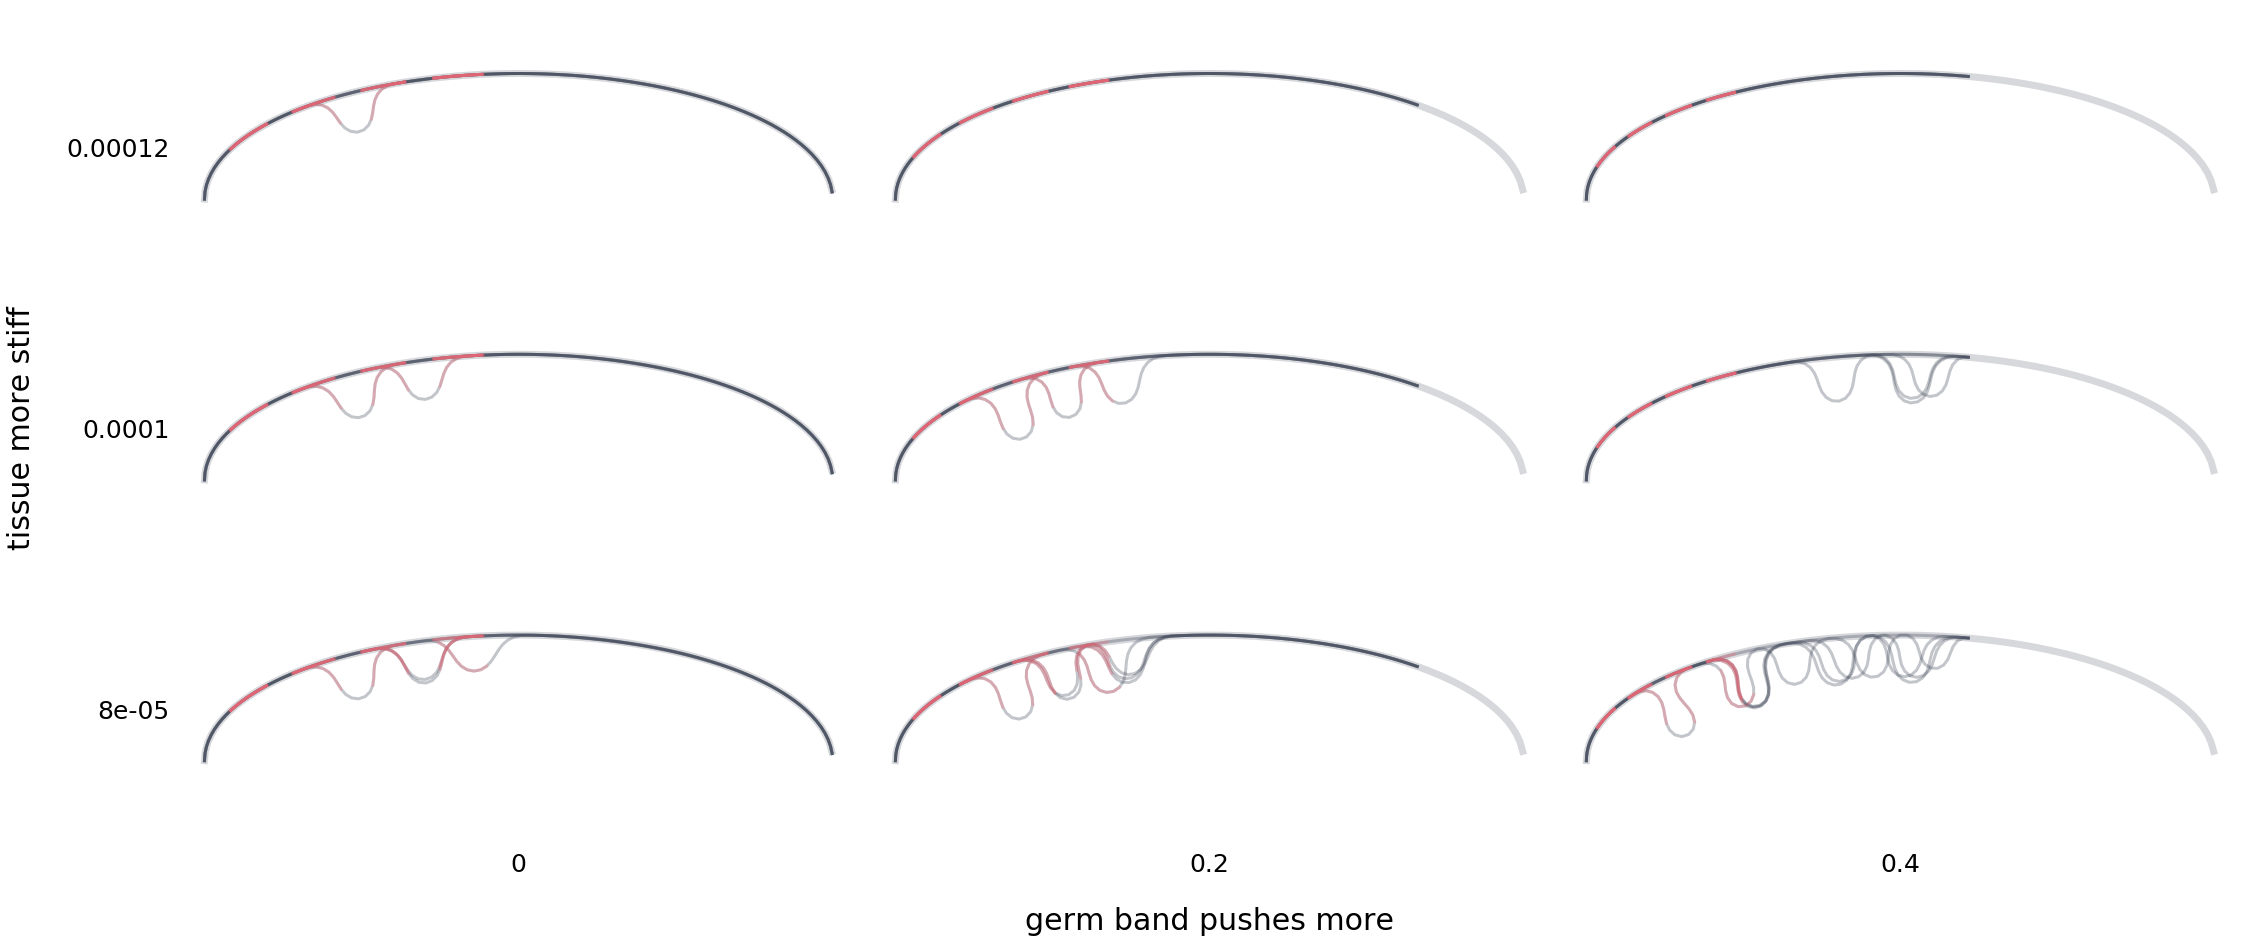

In [203]:
#test plotting
fig = plot_param_sweep(df_final, cols_param, rows_param, 
                         constant_params, constant_param_vals,
                         shape, R_vert_frac = R_vert_frac,  plot_MDs = plot_MDs, 
                         plot_CFs = plot_CFs, CFs = CFs,
                         textsize = 25, labelsize = 30,
                         ax_labels = ['germ band pushes more', 'tissue more stiff'],
                         vitelline_kwargs = vitelline_kwargs, tissue_kwargs = tissue_kwargs, 
                         MD_kwargs = MD_kwargs, CF_kwargs = CF_kwargs)

#fig.savefig(f'figs/CF_MDcurv1_BG_sweep_s{constant_param_vals[1]}.png', bbox_inches='tight')

### Plotting curvature sweep

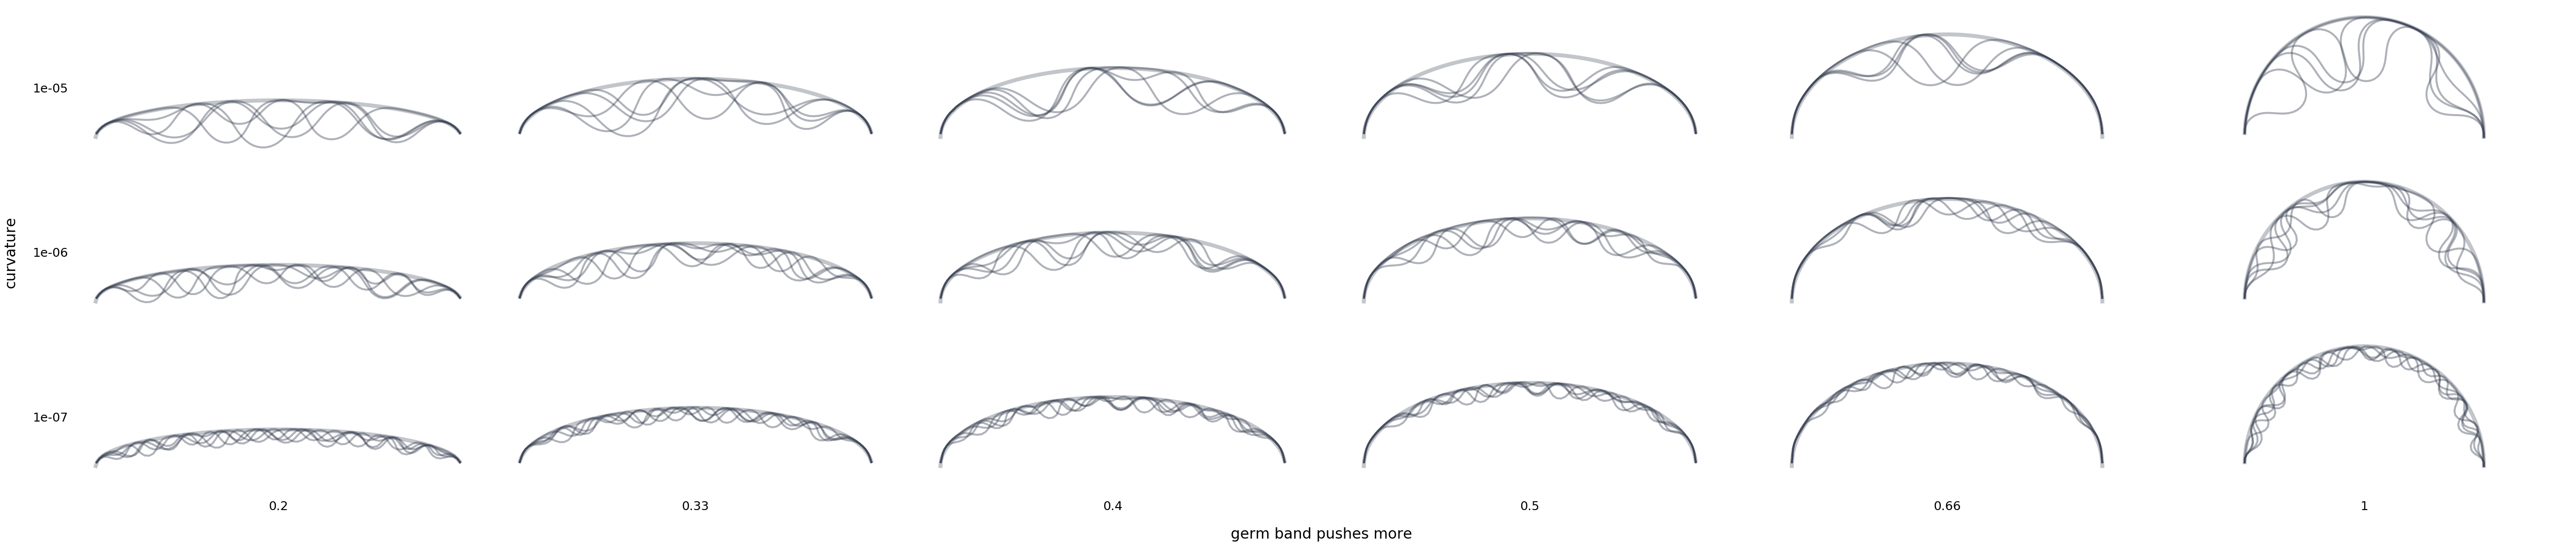

In [34]:
plot_CFs = False
plot_MDs = False
CFs = [[24,25,26], [74,75,76]]

rows_param = 'cf_sweep_K' 
cols_param = 'R_vert_frac'
                     
constant_params = ['uniform_growth']
constant_param_vals = [1.15]

shape = 'line'
q_time = None

fig = plot_param_sweep(df_final, cols_param, rows_param, 
                         constant_params, constant_param_vals,
                         shape, plot_MDs = plot_MDs, 
                         plot_CFs = plot_CFs, CFs = CFs,
                         textsize = 25, labelsize = 30,
                         ax_labels = ['germ band pushes more', 'curvature'],
                         vitelline_kwargs = vitelline_kwargs, tissue_kwargs = tissue_kwargs, 
                         MD_kwargs = MD_kwargs, CF_kwargs = CF_kwargs)

#fig.savefig(f'figs/curvatures.png', dpi = 300, bbox_inches='tight')

### 1D sweeps

In [48]:
plot_CFs = True
CFs = [(50, 51, 52, 53, 54, 55)]
plot_MDs = True
R_vit = 1

CF_color = '#00CECB'
CF_color = '#ABFAA9'
CF_color = '#2CF6B3'

text_col = 'n_furrows'
text = 'av furrows'

vitelline_kwargs = {'c': primary_color, 'lw' : 7, 'alpha': 0.2}
tissue_kwargs = {'c': primary_color, 'lw' : 10, 'alpha' : 1}
CF_kwargs = {'c': CF_color, 'lw' : 10, 'alpha' : 0.8}
MD_kwargs = {'c': accent_color, 'lw' : 10, 'alpha' : 1}

In [253]:
df_frac = df_final[df_final.germ_band_push == 0.2]

rows_param = 'cf_sweep_K'
cols_param = 'germ_band_push'
constant_params = ['R_vert_frac', 'seed', 'number_of_mitotic_domains']
constant_param_vals = [0.4, 2, 4]

constant_params = ['R_vert_frac', 'seed', 'int_curvature_MD', 'int_curvature_CF']
constant_param_vals = [0.4, 0, -1, 10]

fig = plot_param_sweep(df_frac, cols_param, rows_param, 
                         constant_params, constant_param_vals,
                         shape, R_vert_frac = R_vert_frac,  plot_MDs = True, 
                        plot_CFs = True, CFs = CFs,
                        textsize = 25, labelsize = 30,
                         ax_labels = ['', 'tissue more stiff'],
                         vitelline_kwargs = vitelline_kwargs, tissue_kwargs = tissue_kwargs, 
                       MD_kwargs = MD_kwargs, CF_kwargs = CF_kwargs)

#fig.savefig(f'figs/1D_GB_MDcurv_s{constant_param_vals[1]}_T.png', bbox_inches='tight', dpi = 300)

### Single image

In [51]:
df_frac

index         x         y  arclength  arclength_frac  \
240    1200000 -1.000000  0.000000   0.000000        0.000000   
241    1200001 -0.998944  0.018380   0.018410        0.010101   
242    1200002 -0.995826  0.036510   0.036821        0.020202   
243    1200003 -0.990866  0.053941   0.055231        0.030303   
244    1200004 -0.984341  0.070509   0.073642        0.040404   
245    1200005 -0.976583  0.086056   0.092052        0.050505   
246    1200006 -0.967905  0.100526   0.110463        0.060606   
247    1200007 -0.958622  0.113873   0.128873        0.070707   
248    1200008 -0.949289  0.125762   0.147284        0.080808   
249    1200009 -0.940102  0.136357   0.165694        0.090909   
250    1200010 -0.931096  0.145909   0.174900        0.095960   
251    1200011 -0.922332  0.154559   0.184105        0.101010   
252    1200012 -0.913801  0.162465   0.193310        0.106061   
253    1200013 -0.905464  0.169769   0.202515        0.111111   
254    1200014 -0.897252  0.176607   0.211721        0.116162   
255    1200015 -0.888174  0.183803   0.220926        0.121212   
256    1200016 -0.878556  0.191056   0.230131        0.126263   
257    1200017 -0.868538  0.198249   0.239336        0.131313   
258    1200018 -0.858188  0.205334   0.248542        0.136364   
259    1200019 -0.847538  0.212294   0.257747        0.141414   
260    1200020 -0.836614  0.219117   0.276157        0.151515   
261    1200021 -0.825412  0.225812   0.294568        0.161616   
262    1200022 -0.813962  0.232367   0.312978        0.171717   
263    1200023 -0.802304  0.238766   0.331389        0.181818   
264    1200024 -0.790466  0.245002   0.349799        0.191919   
265    1200025 -0.778348  0.251133   0.359005        0.196970   
266    1200026 -0.767813  0.256270   0.368210        0.202020   
267    1200027 -0.757789  0.261000   0.377415        0.207071   
268    1200028 -0.747837  0.265553   0.386620        0.212121   
269    1200029 -0.737592  0.270099   0.395826        0.217172   
...        ...       ...       ...        ...             ...   
14850  1163250  0.137018  0.396227   1.288734        0.707071   
14851  1163251  0.155445  0.395138   1.307145        0.717172   
14852  1163252  0.173862  0.393908   1.325555        0.727273   
14853  1163253  0.192270  0.392537   1.343966        0.737374   
14854  1163254  0.210667  0.391023   1.362376        0.747475   
14855  1163255  0.229051  0.389366   1.380787        0.757576   
14856  1163256  0.247421  0.387563   1.399197        0.767677   
14857  1163257  0.265777  0.385614   1.417608        0.777778   
14858  1163258  0.284115  0.383516   1.436018        0.787879   
14859  1163259  0.302435  0.381268   1.454429        0.797980   
14860  1163260  0.320753  0.378865   1.472839        0.808081   
14861  1163261  0.339052  0.376307   1.491250        0.818182   
14862  1163262  0.357330  0.373591   1.509660        0.828283   
14863  1163263  0.375583  0.370715   1.528071        0.838384   
14864  1163264  0.393810  0.367677   1.546481        0.848485   
14865  1163265  0.412009  0.364472   1.564892        0.858586   
14866  1163266  0.430178  0.361098   1.583302        0.868687   
14867  1163267  0.448313  0.357551   1.601713        0.878788   
14868  1163268  0.466412  0.353827   1.620123        0.888889   
14869  1163269  0.484473  0.349922   1.638534        0.898990   
14870  1163270  0.502492  0.345833   1.656944        0.909091   
14871  1163271  0.520463  0.341554   1.675355        0.919192   
14872  1163272  0.538368  0.337084   1.693765        0.929293   
14873  1163273  0.556165  0.332429   1.712176        0.939394   
14874  1163274  0.573841  0.327587   1.730586        0.949495   
14875  1163275  0.591449  0.322537   1.748997        0.959596   
14876  1163276  0.609014  0.317264   1.767407        0.969697   
14877  1163277  0.626553  0.311752   1.785818        0.979798   
14878  1163278  0.644102  0.305976   1.804228        0.989899   
14879  1163279  0.661508  0.299975   1.82263

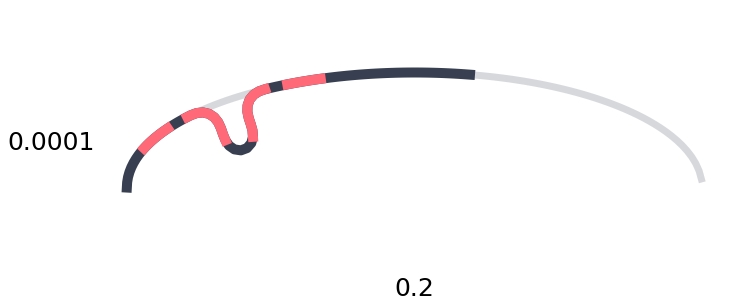

In [53]:
df_frac = df_final[(df_final.germ_band_push == 0.2) & (df_final.cf_sweep_K == 0.0001)]

rows_param = 'cf_sweep_K'
cols_param = 'germ_band_push'
constant_params = ['R_vert_frac', 'int_curvature_MD', 'seed']#, 'seed']#, ]#, 'int_curvature_CF']
constant_param_vals = [0.4, -1, 1]# 2]#, -1]#, 10]

fig = plot_param_sweep(df_frac, cols_param, rows_param, 
                         constant_params, constant_param_vals,
                         shape, R_vert_frac = R_vert_frac,  plot_MDs = plot_MDs, 
                         plot_CFs = False, CFs = CFs,
                         textsize = 25, labelsize = 30,
                         ax_labels = ['', ''],
                         vitelline_kwargs = vitelline_kwargs, tissue_kwargs = tissue_kwargs, 
                         MD_kwargs = MD_kwargs, CF_kwargs = CF_kwargs)

#fig.savefig(f'figs/1D_GB0.2_MDcurv_CF_s{constant_param_vals[1]}_single.png', bbox_inches='tight', dpi = 300)

### Frequency

Want to represent where the folds form along the tissue in different iterations of the simulations. Want to retain information on fold position and ideally fold depth. Also it would be great if each iteration was plotted separately since otherwise it is confusing (can't see whether a single simulation is likely to have two folds or sometimes one and sometimes three)

In [11]:
closest_points = []
new_arclengths = []
new_arclength_fracs = []

for index, row in df_final.iterrows():
    #for each particle in a simulation, grab the closest point on the ellipse
    #and then calculate the arclength from start of tissue to that point
    #and distance to the vitelline membrane (distance between the particle & the closest ellipse point)
    closest_point = np.array(get_closest_ellipse_pt(1, row.R_vert_frac, (row.x, row.y)))
    angle = np.arccos(np.dot(closest_point, np.array([-1,0]))/(np.linalg.norm(closest_point)))
    
    #to get arc length, need to solve the incomplete elliptic integral
    arclength = ellipeinc(angle, 1 - np.square(row.R_vert_frac)/np.square(1))
    arclength_frac = arclength/ellipeinc(np.deg2rad(180), 1 - np.square(row.R_vert_frac)/np.square(1))
    
    closest_points.append(closest_point)
    new_arclengths.append(arclength)
    new_arclength_fracs.append(arclength_frac)
    
closest_points = np.array(closest_points)
dists = np.linalg.norm(df_final[['x', 'y']] - closest_points, axis = 1)

#x,y coords of the closest ellipse point
df_final['cep_x'] = closest_points[:,0]
df_final['cep_y'] = closest_points[:,1]
df_final['dist_to_ellipse'] = dists

df_final['fin_arclength'] = new_arclengths
df_final['fin_arclength_frac'] = new_arclength_fracs

In [12]:
params_to_plot = {'cf_sweep_K' : 0.0001,
                  'germ_band_push': 0.2, 
                  'int_curvature_MD': -1, 
#                  'int_curvature_CF': 10
                 }

In [13]:
params = list(params_to_plot.keys())
param_vals = list(params_to_plot.values())

plot_bool = np.sum(np.abs(df_final[params] - param_vals) < 1e-8, axis = 1) == len(params)

df_plot = df_final[plot_bool]

#df_plot = df_plot[df_plot.seed < 4]

print(np.unique(df_plot.seed))

In [15]:
gb_ext = params_to_plot['germ_band_push']

x_reg = np.linspace(0, 1-gb_ext, 100)
reg_heatmap = pd.DataFrame(index = x_reg)

#since particles end up at different arclengths 
#need to interpolate to make a nice heatmap
for seed in np.unique(df_plot.seed): 
    
    single_seed = df_plot[df_plot.seed == seed][['fin_arclength_frac', 'dist_to_ellipse']]
    
    x = single_seed.fin_arclength_frac#*(1-gb_ext)
    y = single_seed.dist_to_ellipse

    interpolated = interpolate.interp1d(x, y, kind='linear')
    reg_heights = interpolated(x_reg)

    reg_heatmap[seed] = reg_heights

In [16]:
vitelline_kwargs = {'c': primary_color, 'lw' : 7, 'alpha': 0.2}
tissue_kwargs = {'c': primary_color, 'lw' : 15, 'alpha' : 1}
CF_kwargs = {'c': CF_color, 'lw' : 15, 'alpha' : 0.6}
MD_kwargs = {'c': accent_color, 'lw' : 15, 'alpha' : 1}

plot_MDs = True
plot_CFs = False
CFs = [(50, 51, 52, 53, 54, 55)]

7.678960925241111 12.671008454342536
15.962760170652489 21.04142395129269
24.486978409055986 30.34346006125965
34.5996530361586 42.26110238886652


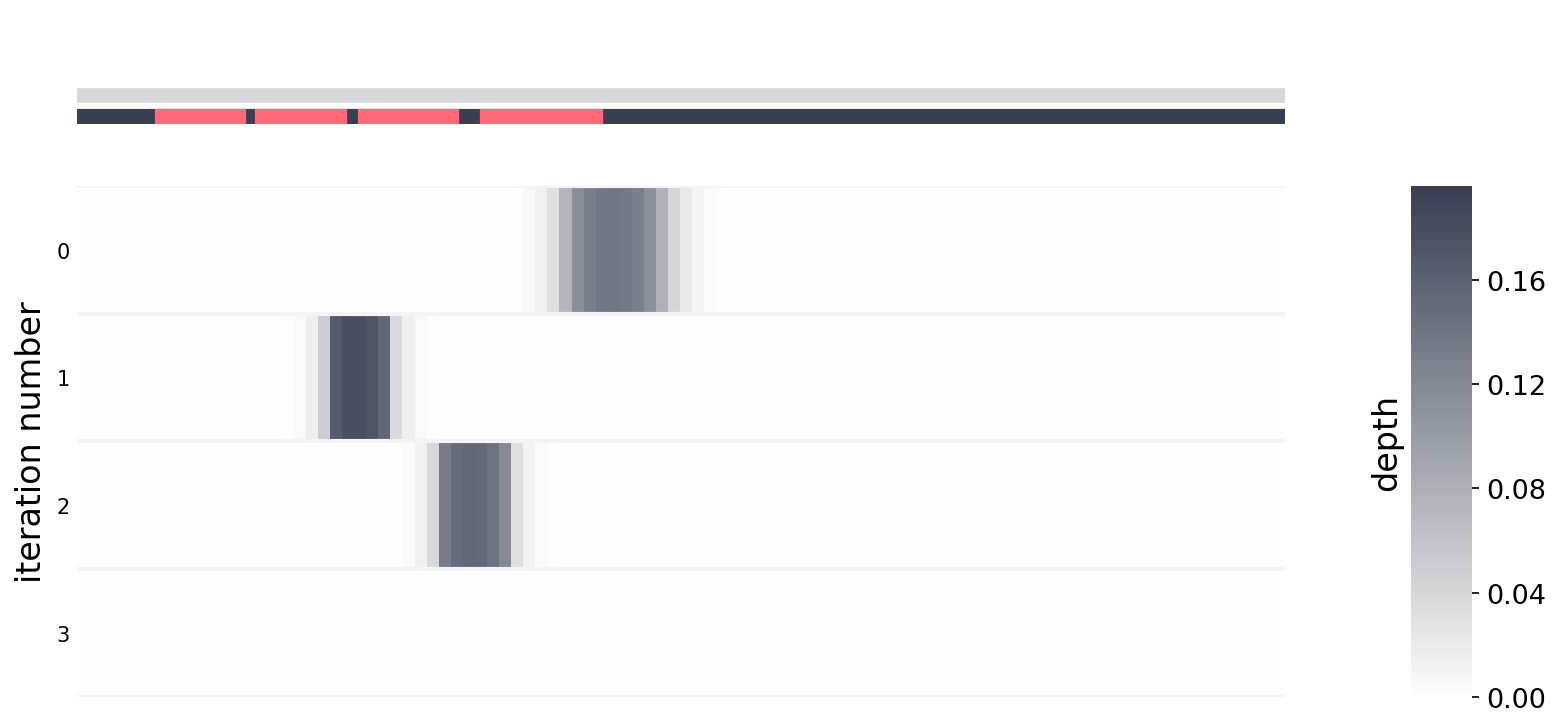

In [19]:
#plot folds as a heatmap (color represents the distance from vitelline membrane)
#this allows to see where the folds form in relation to different tissue 
#characteristics
fig = plt.figure(figsize = (12,6), dpi = 150)

gs = gridspec.GridSpec(2, 2, 
                       height_ratios=[1,1.2*len(np.unique(df_plot.seed))], 
                       width_ratios = [20,1])

ax2 = plt.subplot(gs[2], frame_on = False)
ax1 = plt.subplot(gs[0], frame_on = False, sharex = ax2)
cbar_ax = plt.subplot(gs[3])

#plot vitelline:
vitelline_len = len(reg_heatmap.index)/(1-gb_ext)
ax1.plot([0 , vitelline_len], [1.35e-2,1.35e-2], **vitelline_kwargs)

#plot tissue
ax1.plot([0 , len(reg_heatmap.index)], [0,0], **tissue_kwargs)
ax1.set_ylim(0, 0.05)

#plot MDs
df = df_plot[:120].reset_index()

if plot_MDs: 
    #grabs the indices of particles belonging to mitotic domains
    md_indices = df[df.mitotic_domain.astype(bool)].ID.values
    #this splits the list of all indices of all particles belonging 
    #to mitotic domains into lists of consecutive integers
    #so basically into separate mitotic domains
    mds = [list(g) for k, g in groupby(md_indices, key=lambda i,j=count(): i-next(j))]
    
    for md in mds: 
        #fin_arclength_frac is used - so the plot at the top represents structures in a relaxed 
        #tissue
        md_bool = df_plot.ID.isin(md)
        
        print(np.min(df_plot[md_bool].fin_arclength_frac)*vitelline_len, 
                  np.max(df_plot[md_bool].fin_arclength_frac)*vitelline_len)

        ax1.plot([np.min(df_plot[md_bool].fin_arclength_frac)*vitelline_len, 
                  np.max(df_plot[md_bool].fin_arclength_frac)*vitelline_len],
                 [0,0], **MD_kwargs)
        
if plot_CFs: 
    for CF in CFs: 
        CF_bool = df_plot.ID.isin(CF)
        ax1.plot([np.min(df_plot[CF_bool].fin_arclength_frac)*vitelline_len, 
                  np.max(df_plot[CF_bool].fin_arclength_frac)*vitelline_len], 
                 [0,0], **CF_kwargs)


sns.heatmap(reg_heatmap.T, cmap=get_continuous_cmap(['#ffffff', primary_color]),
            vmax = np.max(df_final.dist_to_ellipse),
            ax = ax2, cbar_ax=cbar_ax, 
            cbar_kws={'label': 'depth'})


cbar_ax.yaxis.label.set_size(label_text_size)
cbar_ax.yaxis.set_label_position('left')
cbar_ax.tick_params(labelsize=tick_size)


for ax in [ax1, ax2]:
    ax.set_xlim(0, len(reg_heatmap.index))#vitelline_len)
    
ax1.set_xticks(np.linspace(0, ax.get_xlim()[1], 11))
ax1.set_xticklabels(np.round(np.linspace(0, 1, 11), 2))
ax1.set_yticks([])

ax2.set_xticks([])
ax2.set_ylabel('iteration number', fontsize=label_text_size)
ax2.set_yticklabels(np.arange(0, reg_heatmap.shape[1]).astype(int), 
                   rotation=0, horizontalalignment='right')
ax2.tick_params(axis='both', which='both', length=0)

#would be great to set color behind the plot to light gray(so that it is obvious that the white 
#of the colormap is a colormap data point and not just nothing being there on the plot)
#ax2.set_facecolor('#F3F4F7')
#cbar_ax.set_facecolor('#F3F4F7')

for i in range(reg_heatmap.T.shape[1]+1):
    ax.axhline(i, color='#F3F4F7', lw=2)

    
#plt.savefig(f'{fig_folder}/{sweep}_GB{gb_ext}_fold_freq.png', bbox_inches='tight', dpi = 300)

#### Caution
This plot is the best I could come up with but is slightly misleading. The tissue on the top is plotted using the final (relaxed) coordinates - usually from the seed = 0. However, since each iteration will relax the tissue in a slightly different way, the tissue on the top is not necesarily true for all heatmaps (eg if the fold will be next to MD 4, this MD will appear longer than the remaining MDs)

#### Ridge plot - alternative frequency plotting?

In [131]:
long = reg_heatmap.unstack().reset_index(name='value')
long.rename(columns={'level_0': 'seed', 'level_1': 'dist'}, inplace=True)

In [214]:
x_reg = np.linspace(np.min(x), 1.38, 100)
#x_reg = np.linspace(np.min(x), 1-0.4, 100)
reg_heatmap = pd.DataFrame(index = x_reg)

for seed in np.unique(df_plot.seed): 
    
    single_seed = df_plot[df_plot.seed == seed][['fin_arclength', 'dist_to_ellipse']]
    
    x = single_seed.fin_arclength
    y = single_seed.dist_to_ellipse

    interpolated = interpolate.interp1d(x, y, kind='linear')
    reg_heights = interpolated(x_reg)

    reg_heatmap[seed] = reg_heights

In [215]:
gs = (grid_spec.GridSpec(len(reg_heatmap.columns),1))

fig = plt.figure(figsize=(1*len(reg_heatmap.columns),8), dpi = 150)

#creating empty list
ax_objs = []

spines = ["top","right","left","bottom"]

for i, col in enumerate(reg_heatmap.columns[:10]):
    
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    
    
    ax_objs[-1].plot(reg_heatmap[col].index, -reg_heatmap[col].values, 
                    c = 'w', lw = 5)
    ax_objs[-1].plot(reg_heatmap[col].index, -reg_heatmap[col].values, 
                    c = 'k', lw = 3)
    
    #print(seed, np.max(reg_heatmap[col].values))
    
    
    ax_objs[-1].set_aspect('equal', adjustable='box')
    
    ax_objs[-1].set_xlim(0, 1.38)
    ax_objs[-1].set_ylim(-np.max(df_plot.dist_to_ellipse), 0.05)
    
    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])
    ax_objs[-1].set_ylabel('')

    ax_objs[-1].set_xticklabels([])
    

[axi.set_axis_off() for axi in ax_objs]    
gs.update(hspace=-0.5)    
plt.tight_layout()

/sw/apps/python3/3.6.5/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
